In [82]:
import sys
sys.path.append('/home/potzschf/repos/')
from helperToolz.helpsters import *
from helperToolz.evapo import *
import geopandas as gpd
import tarfile
from pyproj import CRS
from collections import Counter
from joblib import Parallel, delayed
workhorse = True

if workhorse:
    origin = 'Aldhani/eoagritwin/'
else:
    origin = ''

In [ ]:
#### get path and rows of scenes that have data for the chosen AOI (e.g. Brandenburg)
aoi_set_man = 'Brandenburg'
landsat_epsg = '32633'
res = 30

# load shapefiles and check projections
ger = gpd.read_file(f'/data/{origin}misc/gadm41_DEU_shp/gadm41_DEU_1.shp')
aoi = ger[ger['NAME_1'] == aoi_set_man]

orbits = gpd.read_file(f'/data/{origin}misc/WRS2_descending_0/WRS2_descending.shp')

if aoi.crs != orbits.crs:
    orbits = orbits.to_crs(aoi.crs)

# find overlapping paths/rows
intersecting = orbits[orbits.intersects(aoi.unary_union)]
path_rows = [f'{p}_{r}' for p, r in zip(intersecting['PATH'], intersecting['ROW'])]

In [ ]:
# get all paths from downloaded products --> subsetted to paths and rows
landsat_files = getFilelist(f'/data/{origin}et/Landsat/raw/', '.tar.gz', deep=True)

# create a look-up dictionary for time subsets
lookUp = LandsatETFileManager(landsat_files)

In [ ]:
#### do the compositing monthly
year = 2024
month = 7
# check if temp_folder is empty and delete everything if not
tempF = f'/data/{origin}et/Landsat/extracts/'
if len(getFilelist(tempF, '.nc')) > 0:
    for file in getFilelist(tempF, '.nc'):
        os.remove(file)
    print('kill complete')
# subset data and extract
for landsat_file in lookUp.get_by_year_and_month(year, month):
    with tarfile.open(landsat_file, 'r:gz') as tar:
        tar.extractall(tempF)
# remove not needed files
for ending in ['.xml', '.txt']:
    trash_list = getFilelist(tempF, ending)
    for trash in trash_list:
        os.remove(trash)

In [ ]:
# get maximum bounding box based on aoi and nc data
nc_files = getFilelist(f'/data/{origin}et/Landsat/extracts/', '.nc')
# min-maxs for data
file_Xmin = []
file_Xmax = []
file_Ymin = []
file_Ymax = []

for nc_file in nc_files:
    file_Xmin.append(xr.open_dataset(nc_file).coords['XDim_ETA'][0])
    file_Xmax.append(xr.open_dataset(nc_file).coords['XDim_ETA'][-1])
    file_Ymin.append(xr.open_dataset(nc_file).coords['YDim_ETA'][-1])
    file_Ymax.append(xr.open_dataset(nc_file).coords['YDim_ETA'][0])

dXmin = min(file_Xmin) # western border
dXmax = max(file_Xmax) # eastern border
dYmin = min(file_Ymin) # southern border
dYmax = max(file_Ymax) # northern border

# min-max aoi
aXmin, aYmin, aXmax, aYmax = aoi.to_crs(CRS.from_epsg(landsat_epsg)).total_bounds

# get bounding box for array and later export
nXmin = int(math.floor((aXmin - dXmin) / res) * res + dXmin)
nXmax = int(dXmax - (math.floor((dXmax - aXmax) / res) * res))
nYmin = int(math.floor((aYmin - dYmin) / res) * res + dYmin)
nYmax = int(dYmax - (math.floor((dYmax - aYmax) / res) * res))

# create empty np array
rows = int(((nYmax - nYmin) / res) + 1)
cols = int(((nXmax - nXmin) / res) + 1)
bands = len(lookUp.get_all_dates_by_year_and_month(year, month, False))
block = np.empty((rows, cols, bands), dtype=np.float32)

In [ ]:
# fill it
for i, nc_file in enumerate(nc_files):
    print(i)
    values = xr.open_dataset(nc_file).data_vars['ETA'].values
    fXmin = int(file_Xmin[i])
    fXmax = int(file_Xmax[i])
    fYmin = int(file_Ymin[i])
    fYmax = int(file_Ymax[i])

    if nXmin - fXmin < 0: 
        start_col_aoi = int((fXmin - nXmin) / 30)
        start_col_dat = 0
    elif nXmin - fXmin > 0:
        start_col_aoi = 0
        start_col_dat = int((nXmin - fXmin) / 30)
    else:
        start_col_aoi = 0
        start_col_dat = 0


    if nXmax - fXmax < 0:
        end_col_dat = values.shape[1] - int((fXmax-nXmax)/30)
        end_col_aoi = cols
    elif nXmax - fXmax > 0:
        end_col_dat = values.shape[1]
        end_col_aoi = cols - int((nXmax - fXmax) / 30)
    else:
        end_col_dat = values.shape[1]
        end_col_aoi = cols


    if nYmax - fXmax < 0:
        start_row_dat = int((fYmax - nYmax) / 30)
        start_row_aoi = 0
    elif nYmax - fXmax > 0:
        start_row_dat = 0
        start_row_aoi = int((nYmax - fYmax) / 30)
    else:
        start_row_dat = 0
        start_row_aoi = 0


    if nYmin - fYmin < 0:
        end_row_dat = values.shape[0]
        end_row_aoi = rows - int((nYmin - fYmin) / 30)
    elif nYmin - fYmin > 0:
        end_row_dat = values.shape[0] - int((nYmin - fYmin) / 30)
        end_row_aoi = rows 
    else:
        end_row_dat = values.shape[0]
        end_row_aoi = rows
    
    pList = [start_row_dat, end_row_dat, start_col_dat, end_col_dat, start_row_aoi, end_row_aoi, start_col_aoi, end_col_aoi]
    if any(x < 0 for x in pList):
        print('shit')
        continue
    else:
        block[start_row_aoi:end_row_aoi, start_col_aoi:end_col_aoi, i] = values[start_row_dat:end_row_dat, start_col_dat:end_col_dat]

In [ ]:
#### take care of overlap due due multiple scenes per day
day_counts = Counter(lookUp.get_all_dates_by_year_and_month(year, month, False))

dummy = 0
cumulative_day_counts_end = []

for _, count in sorted(day_counts.items()):
    dummy += count
    cumulative_day_counts_end.append(dummy)

cumulative_day_counts_start = np.insert(cumulative_day_counts_end, 0 ,0)

# try fancy list aggregation
cumulative_day_counts_start = np.array(cumulative_day_counts_start)
cumulative_day_counts_end = np.array(cumulative_day_counts_end)

### too slow
# stack_list = [
#     np.nanmedian(block[:, :, start:end], axis=2)
#     for start, end in zip(cumulative_day_counts_start[:-1], cumulative_day_counts_end)
# ]

# fin_block = np.dstack(stack_list)


KeyboardInterrupt: 

In [83]:
# Define the function to compute median for one slice
def compute_daily_median(start, end):
    return np.nanmedian(block[:, :, start:end], axis=2)

# Run in parallel
stack_list = Parallel(n_jobs=31)(  # -1 uses all available CPU cores
    delayed(compute_daily_median)(start, end)
    for start, end in zip(cumulative_day_counts_start[:-1], cumulative_day_counts_end)
)

In [84]:
fin_block = np.dstack(stack_list)

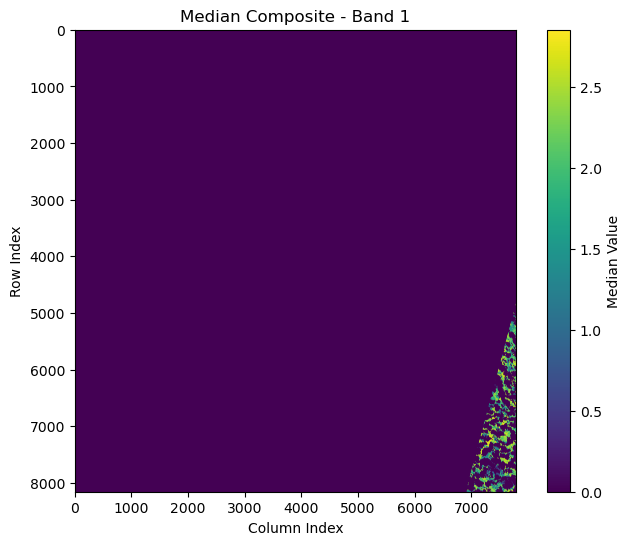

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a band index to visualize (e.g., 0 = first day)
band_idx = 0

# Safety check to ensure the index is valid
if fin_block.shape[2] > band_idx:
    plt.figure(figsize=(8, 6))
    plt.imshow(fin_block[:, :, band_idx], cmap='viridis')
    plt.colorbar(label='Median Value')
    plt.title(f'Median Composite - Band {band_idx + 1}')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()
else:
    print(f"Band index {band_idx} is out of bounds. fin_block has {fin_block.shape[2]} bands.")

In [86]:
# tiff export
import rasterio
from rasterio.transform import from_origin

# Assuming the dataset has spatial resolution info
transform = from_origin(nXmin, nYmax, res, res)

# Define output GeoTIFF filename
output_filename = f'/data/{origin}et/Landsat/check.tif'

# Open a new GeoTIFF file for writing
with rasterio.open(output_filename, 'w', driver='GTiff', 
                   height=fin_block.shape[0], width=fin_block.shape[1],
                   count=fin_block.shape[2], dtype=fin_block.dtype,
                   crs=f'EPSG:{landsat_epsg}', transform=transform) as dst:
    dst.write(fin_block.transpose(2, 0, 1))

In [ ]:
if len(getFilelist(tempF, '.nc')) > 0:
    for file in getFilelist(tempF, '.nc'):
        os.remove(file)
    print('kill complete')

In [66]:
print(np.nanmin(fin_block), np.nanmax(fin_block))  # Check data range

0.0 0.0
